<a href="https://colab.research.google.com/github/sanyalodha/QM2/blob/main/Part_2_Maps_for_QM2_DATASET_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset 2: Cleaning, Processing and Analysis**

**Imports**

Source for Dataset 2:
*   https://www.pewresearch.org/religion/religious-landscape-study/compare/party-affiliation/by/state/
*   https://www.pewresearch.org/religion/religious-landscape-study/compare/views-about-abortion/by/state/



In [2]:
!mkdir data
!curl https://www.ucl.ac.uk/~uclqcl3/BASC0005/Dataset2.csv -o data/Dataset2.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2437  100  2437    0     0   2421      0  0:00:01  0:00:01 --:--:--  2422


In [3]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import statistics
import pandas as pd
import numpy as np
import seaborn as sns
import pylab
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import glm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.anova import anova_lm



In [4]:
df = pd.read_csv("data/Dataset2.csv")

df.head()

,State,Legal in all/most cases,Illegal in all/most cases,Don't know,Republican/lean Rep.,No lean,Democrat/lean Dem.,Religion is Very Important
0,Alabama,0.37,0.58,0.04,0.52,0.13,0.35,0.77
1,Alaska,0.63,0.34,0.03,0.39,0.29,0.32,0.41
2,Arizona,0.49,0.46,0.04,0.40,0.21,0.39,0.51
3,Arkansas,0.38,0.60,0.02,0.46,0.16,0.38,0.70
4,California,0.57,0.38,0.05,0.30,0.21,0.49,0.47


**Correlation: State Political Affiliation and Legality of Abortion**

*Boxplot*

[Text(0, 0, 'Democrat'), Text(1, 0, 'Republican')]

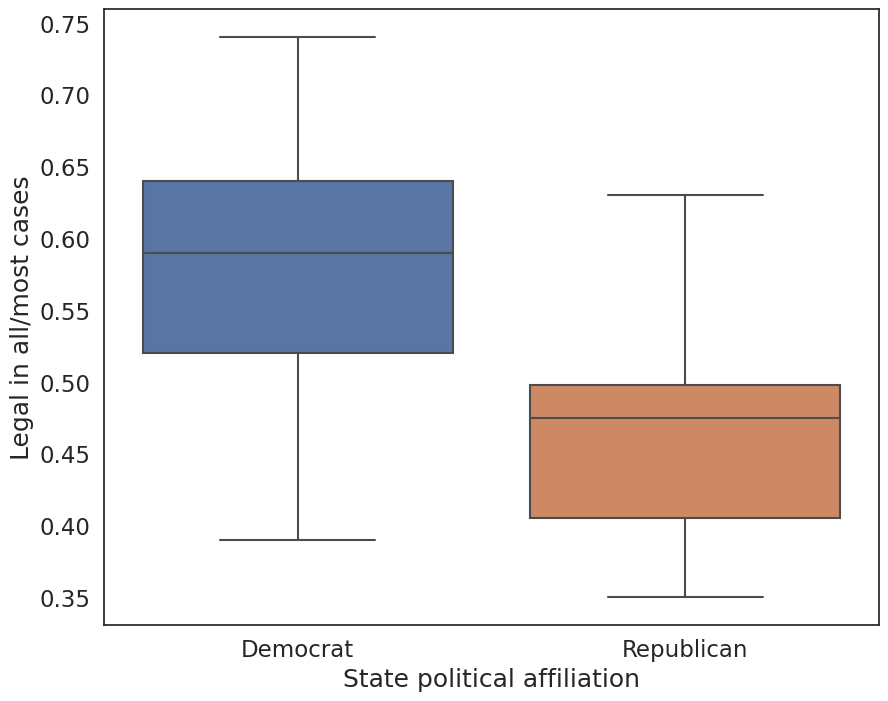

In [5]:
df['State political affiliation'] = df['Republican/lean Rep.']>df['Democrat/lean Dem.']
pylab.rcParams['figure.figsize'] = (10., 8.)
sns.set(font_scale=1.5)
sns.set_style("white")
sns.boxplot(data=df , x='State political affiliation', y='Legal in all/most cases').set_xticklabels(['Democrat', 'Republican'])


From the above box plot, democrat states appear to be more pro-abortion than republican states and they have a higher mean proportion of adults who think abortion should be legal in all or most cases. To verify the significance of the observed difference in means, a t-test is performed on the 2 means.

In [6]:
republican = df[df['State political affiliation']==1]
democrat = df[df['State political affiliation']==0]

t = stats.ttest_ind(republican['Legal in all/most cases'], democrat['Legal in all/most cases'], equal_var=False)
print(t)

TtestResult(statistic=-5.4042136927838165, pvalue=1.9859913557278666e-06, df=48.225337467188254)


The resulting t-statistic is -5.4042, with a p-value of 1.986e-06 which is smaller than 1%. This means that the difference in means is statistically significance at 1% critical value. It is safe to say democrat states are more pro-abortion than republican states.

Text(0.5, 1.0, 't-distribution, df = 49')

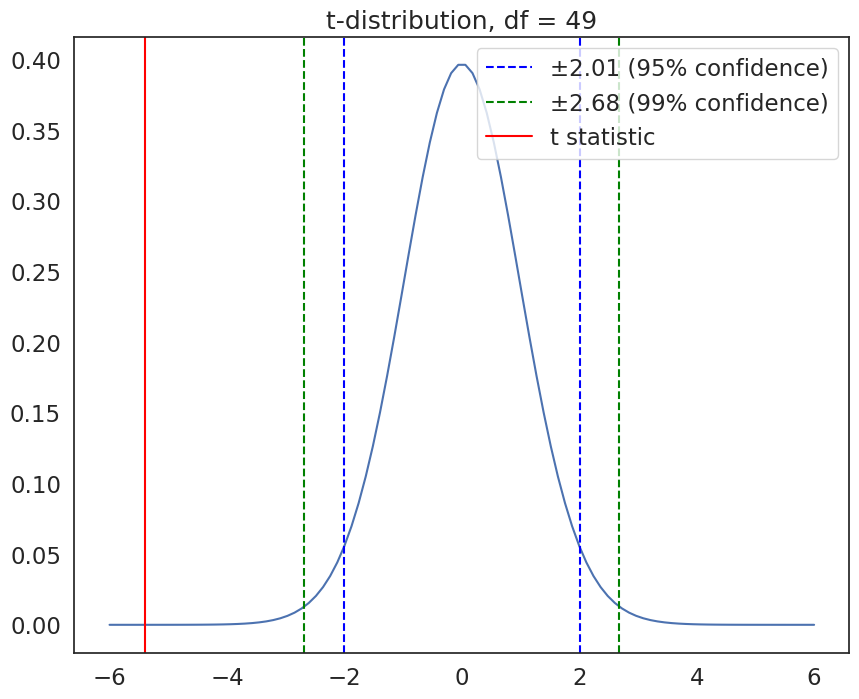

In [7]:
degF= republican['Legal in all/most cases'].count() + democrat['Legal in all/most cases'].count() - 2
x=np.linspace(-6, 6, 100)
plt.plot(x, stats.t.pdf(x, degF))

critVal95 = stats.t.ppf(q=1-.05/2,df=degF)
plt.axvline(critVal95, color='blue', linestyle='dashed', linewidth=1.5,label=('±' + str(round(critVal95, 2)) + ' (95% confidence)'))
plt.axvline(-critVal95, color='blue', linestyle='dashed', linewidth=1.5)

critVal99 = stats.t.ppf(q=1-.01/2,df=degF)
plt.axvline(critVal99, color='green', linestyle='dashed', linewidth=1.5,label=('±' + str(round(critVal99, 2)) + ' (99% confidence)'))
plt.axvline(-critVal99, color='green', linestyle='dashed', linewidth=1.5)

plt.axvline(t.statistic, color='red', linestyle='solid', linewidth=1.5, label='t statistic')

plt.legend()
plt.title('t-distribution, df = ' + str(degF))

The above graph visualises the result of the t-test. We can see the t-statistic is far away to the left tail from the critical values.

Having the conclusion that democrat states are more pro-abortion, we would like to quantify the effect of state political affiliation on the proportion of adults who think abortion should be legal in all or most cases using regression models. The below table shows summary statictis for this data set.

In [8]:
df.describe()

,Legal in all/most cases,Illegal in all/most cases,Don't know,Republican/lean Rep.,No lean,Democrat/lean Dem.,Religion is Very Important
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,0.529216,0.428431,0.042549,0.392157,0.177843,0.430000,0.526471
std,0.099012,0.097578,0.011974,0.084506,0.031325,0.083929,0.106486
min,0.350000,0.220000,0.020000,0.110000,0.100000,0.250000,0.320000
25%,0.470000,0.345000,0.030000,0.330000,0.160000,0.385000,0.455000
50%,0.520000,0.450000,0.040000,0.410000,0.180000,0.420000,0.510000
75%,0.615000,0.500000,0.050000,0.440000,0.190000,0.475000,0.595000
max,0.740000,0.600000,0.070000,0.570000,0.290000,0.730000,0.770000


Before building a model, it is important to look into the potential predicters to see if there is multicollinearity. Let's have a brief idea by looking at the correlation matrix.

Text(0.5, 1.0, 'Correlation Matrix')

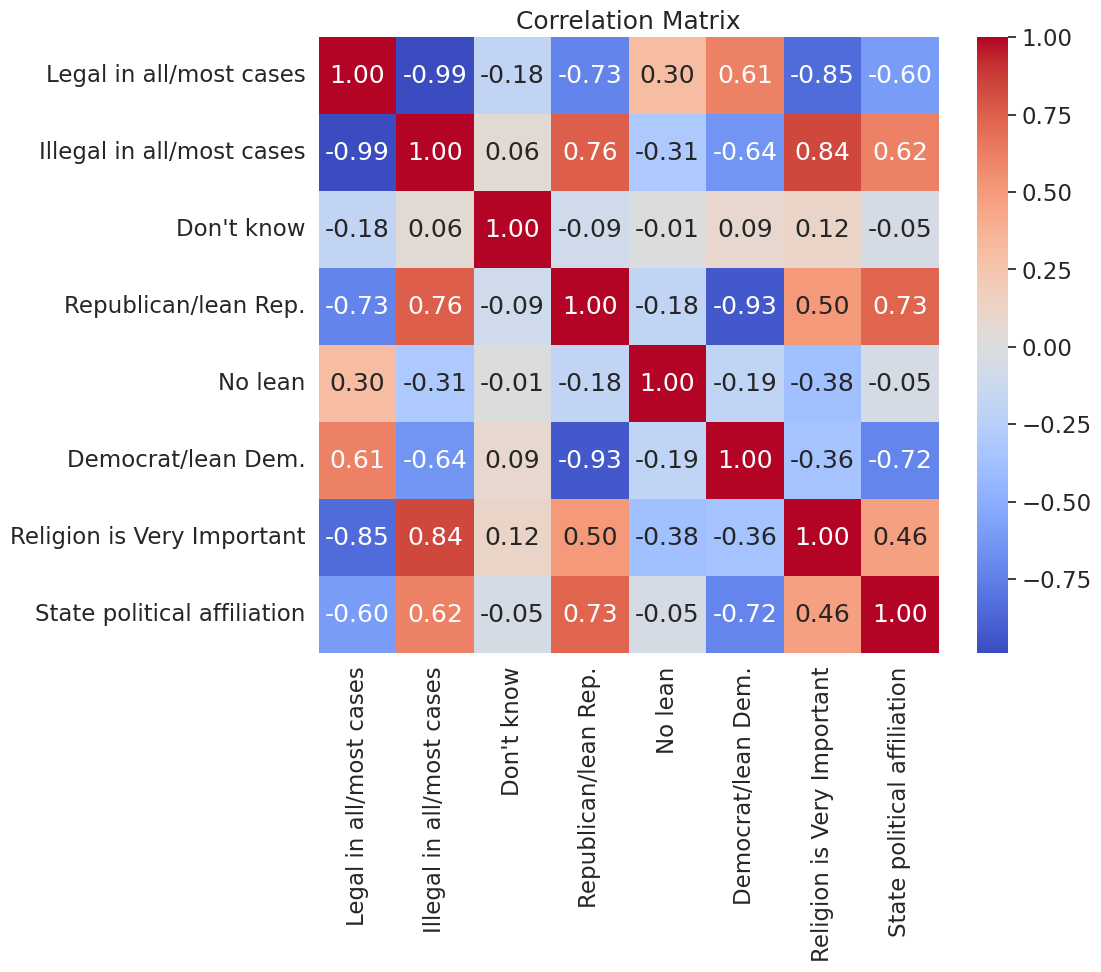

In [9]:
sns.heatmap(df.corr(numeric_only=True), # plot a correlation matrix
            annot=True, # show the correlation values on the plot
            fmt=".2f", # set the format of the correlation values to be two decimal places
            cmap='coolwarm') # set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix')

# 'Republican/lean Rep.' and 'Democrat/lean Dem.' have a very high correlation (absolute term)
# likely to have multicollinearity

From the above matrix, we can see that Republican/lean Rep. and Democrat/lean Dem. have a very strong correlation of -0.93. They are likely to cause multicollinearity if we include both as predictors. To be more rigorous, we use the below function from the workshops to calculate VIF and remove variables with the largest VIF and exceed the threshold.

In [10]:
# calculating VIF
# This function is amended from: https://stackoverflow.com/a/51329496/4667568

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const as const should not be removed
        vif_df = vif_df.drop('const')

        # drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)

        print('Max VIF:', vif_df.VIF.max())

        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break
    return df

vif = drop_column_using_vif_(df[['Republican/lean Rep.', 'No lean', 'Democrat/lean Dem.', 'Religion is Very Important']], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif.columns)

Max VIF: 365.2168607946241
Dropping: Democrat/lean Dem.
Max VIF: 1.5076703911783478
The columns remaining after VIF selection are:
Index(['Republican/lean Rep.', 'No lean', 'Religion is Very Important'], dtype='object')


The remaining variables are 'Republican/lean Rep.', 'No lean' and 'Religion is Very Important'. 'Religion is Very Important' is not applied at the moment since we first focus on political affiliation. Now, we fit a regression model of Legal in all/most cases on Republican/lean Rep.

In [11]:

model= ols('Q("Legal in all/most cases") ~  Q("Republican/lean Rep.")', data=df).fit() # fit the model
print(model.summary()) # print the summary

# slope = -0.8525
# p-value = 0.000


                                 OLS Regression Results                                 
Dep. Variable:     Q("Legal in all/most cases")   R-squared:                       0.529
Model:                                      OLS   Adj. R-squared:                  0.520
Method:                           Least Squares   F-statistic:                     55.14
Date:                          Mon, 15 Jan 2024   Prob (F-statistic):           1.46e-09
Time:                                  18:00:58   Log-Likelihood:                 65.301
No. Observations:                            51   AIC:                            -126.6
Df Residuals:                                49   BIC:                            -122.7
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [12]:
print('slope: ' + str(model.params[1]))
print('p-value: ' + str(model.pvalues[1]))

slope: -0.8525496699651836
p-value: 1.4584861682144586e-09


In the model, the slope coefficient is -0.8525. This means on average, every additional 1% increase in lean republican population in a state is associated with 0.8525% decrease in pro-abortion population. Moreover, the R-squared value is 0.529, which means 52.9% of the variation in pro-abortion population can be explained by this regression model.

The p-value of the slope is 1.4585e-09, which is smaller than 1%. So, the lean republican predictor is statistically significant at 1% significance level, i.e. the slope is different from 0. Then, we move on to residual analysis.

Text(0.5, 1.0, 'Q-Q Plot')

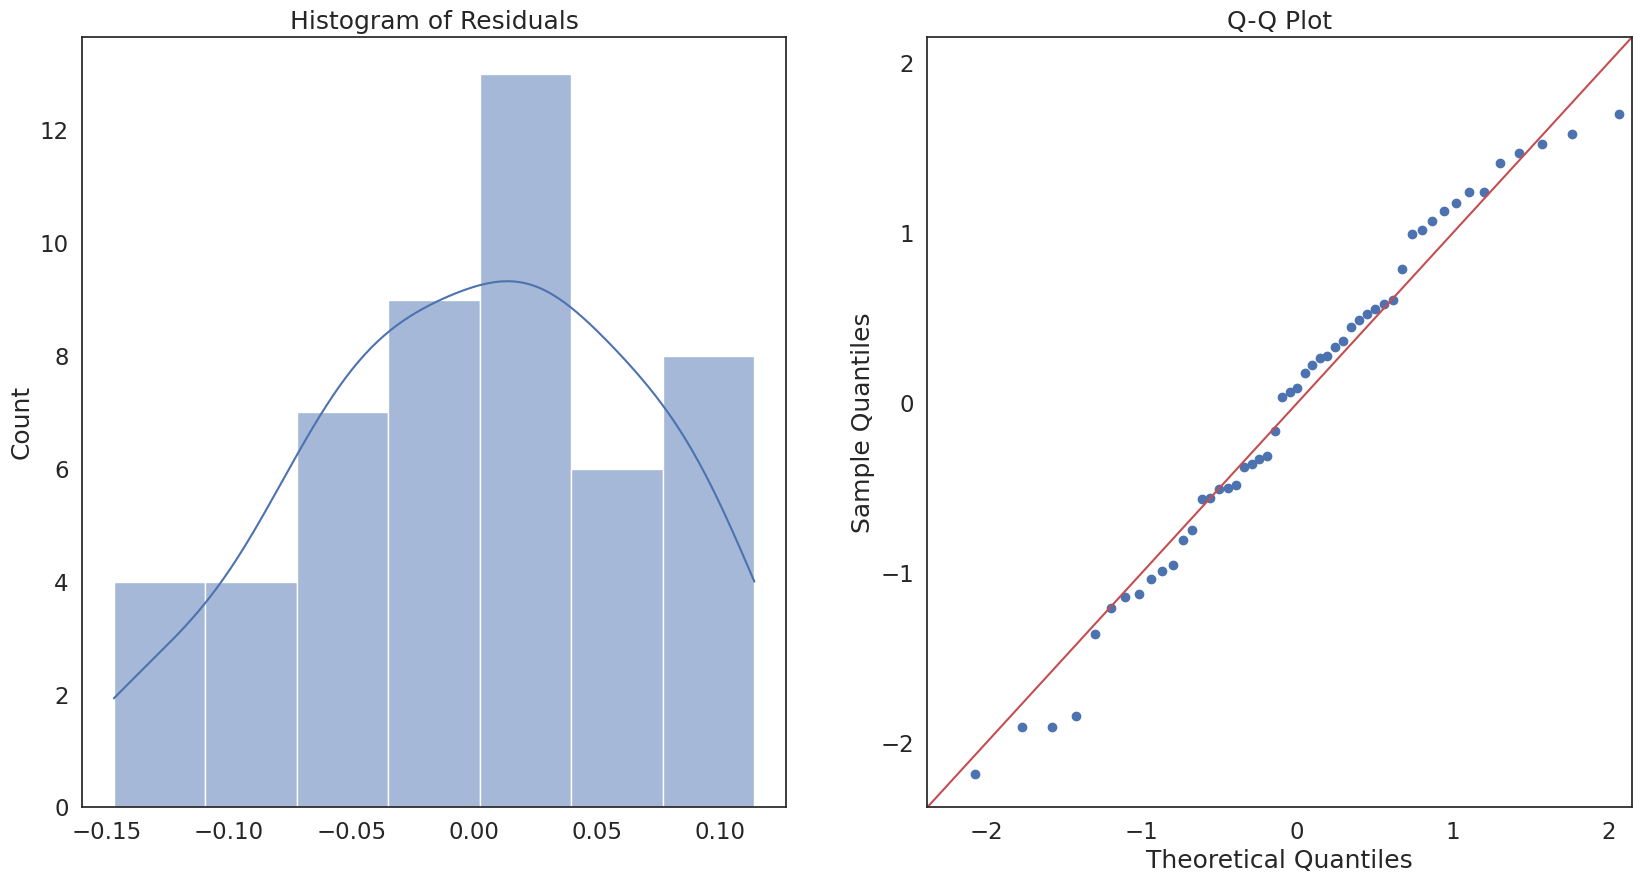

In [13]:
residuals = model.resid # get the residuals

# make the figure wider
plt.rcParams["figure.figsize"] = [20, 10]

f, axes = plt.subplots(1, 2)
sns.histplot(residuals, kde=True, ax=axes[0]) # plot the residuals
axes[0].set_title('Histogram of Residuals') # add a title

sm.qqplot(residuals, line='45', fit=True,  ax=axes[1]) # plot the residuals
axes[1].set_title('Q-Q Plot') # add a title

# residuals follow closely to normal distribution


The left graph above shows a histogram of residuals, which has a standard bell shape and looks like normal distribution. The right graph shows the Q-Q plot of the residuals, which lie very close to the red line, further suggesting the redisuals follow normal distribution.

The VIF of the no lean variable does not exceed the threshold so it may still be a potential predictor. We add this to the model:

In [14]:
model2= ols('Q("Legal in all/most cases") ~  Q("Republican/lean Rep.") + Q("No lean")', data=df).fit() # fit the model
print(model2.summary()) # print the summary


                                 OLS Regression Results                                 
Dep. Variable:     Q("Legal in all/most cases")   R-squared:                       0.560
Model:                                      OLS   Adj. R-squared:                  0.541
Method:                           Least Squares   F-statistic:                     30.49
Date:                          Mon, 15 Jan 2024   Prob (F-statistic):           2.85e-09
Time:                                  18:00:59   Log-Likelihood:                 66.985
No. Observations:                            51   AIC:                            -128.0
Df Residuals:                                48   BIC:                            -122.2
Df Model:                                     2                                         
Covariance Type:                      nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [15]:
anova = anova_lm(model, model2)
print(anova)

# p value is not very small (not significant at 5%)
# choose the simpler model (principle of parsimony)

   df_resid       ssr  df_diff   ss_diff         F    Pr(>F)
0      49.0  0.230641      0.0       NaN       NaN       NaN
1      48.0  0.215910      1.0  0.014731  3.274976  0.076608


The p-value of the "No lean" predictor is 0.077, which is greater than 0.05. This variable is not statistically significant at 0.05. For simplicity (principle of parsimony), the variable is dropped.

In [16]:
table=summary_col( # create a regression table
    [model], # pass the models to the summary_col function
    stars=True, # add stars denoting the p-values of the coefficient to the table; * p<0.05, ** p<0.01, *** p<0.001
    float_format='%0.3f', # set the decimal places to 3
    model_names=['Legal in all/most cases ~ Republican/lean Rep.'], # set the name of the model
    info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))}) # add the number of observations to the table

print(table)


                          Legal in all/most cases ~ Republican/lean Rep.
------------------------------------------------------------------------
Intercept                 0.864***                                      
                          (0.046)                                       
Q("Republican/lean Rep.") -0.853***                                     
                          (0.115)                                       
R-squared                 0.529                                         
R-squared Adj.            0.520                                         
N                         51                                            
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Our model considering only political affiliation is summarized in the above regression table.

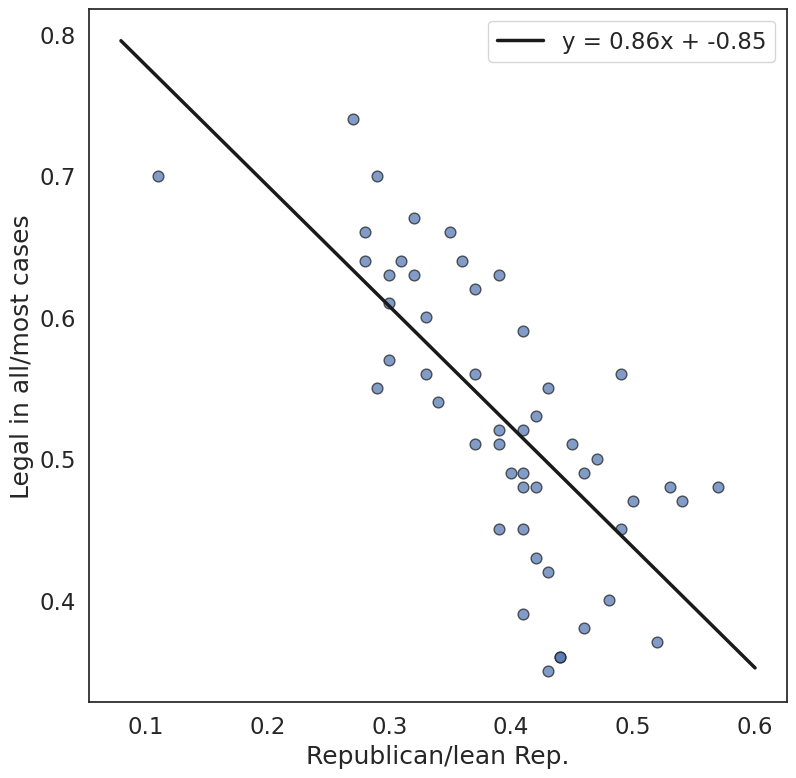

In [17]:
fig, ax = plt.subplots(figsize = (9, 9))

# Add scatterplot
ax.scatter(df['Republican/lean Rep.'], df['Legal in all/most cases'], s=60, alpha=0.7, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(df['Republican/lean Rep.'], df['Legal in all/most cases'], deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0.08, 0.6, num=100)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="k", lw=2.5, label=('y = ' + str(round(model.params[0], 2)) + 'x + ' + str(round(model.params[1], 2))))
ax.set(xlabel='Republican/lean Rep.')
ax.set(ylabel='Legal in all/most cases')
ax.legend()

The graph shows the regression line of our simple linear regression model y = 0.86x + -0.85.

Next, we include more predictors into our model. We consider the effect of religiosity on people's view of abortion as identified in literature review.

In [18]:
model3 = ols('Q("Legal in all/most cases") ~  Q("Republican/lean Rep.") + Q("Religion is Very Important")', data=df).fit()
print(model3.summary())

# lean Rep: -0.4763
# religiosity: -0.5987
# p-values: 0.000, significant at 1%

                                 OLS Regression Results                                 
Dep. Variable:     Q("Legal in all/most cases")   R-squared:                       0.841
Model:                                      OLS   Adj. R-squared:                  0.834
Method:                           Least Squares   F-statistic:                     126.9
Date:                          Mon, 15 Jan 2024   Prob (F-statistic):           6.81e-20
Time:                                  18:01:00   Log-Likelihood:                 92.968
No. Observations:                            51   AIC:                            -179.9
Df Residuals:                                48   BIC:                            -174.1
Df Model:                                     2                                         
Covariance Type:                      nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------

In this model, the coefficient of lean republican variable is -0.4763. This means on average, every additional 1% increase in lean republican population in a state is associated with 0.4763% decrease in pro-abortion population. The coefficient of religiosity predictor is -0.5987, meaning that  on average, every additional 1% increase in population who think religion is very important results in 0.5987% decrease in pro-abortion population.

The p-values of both predictors are 0.000, which are smaller than 1%. So, both predictors are statistically significant at 1% significance level, i.e. the coefficient are different from 0.

Moreover, the R-squared value is 0.841, which means 84.1% of the variation in pro-abortion population can be explained by this regression model. The adjusted R-squared value is 0.834, which is much higher than the simple linear regression model (0.530). The adjusted R-squared value adjusts the R-squared value by penalising excessive predictors. So, a higher R-squared value suggests that the additional variables of being Republican/Republican-leaning and having a high importance of religion added value to the model, indicating the 2-variable model is better than the original model.

In [19]:
table3=summary_col( # create a regression table
    [model, model3], # pass the models to the summary_col function
    stars=True, # add stars denoting the p-values of the coefficient to the table; * p<0.05, ** p<0.01, *** p<0.001
    float_format='%0.3f', # set the decimal places to 3
    model_names=['Legal in all/most cases ~ Republican/lean Rep.', 'Legal in all/most cases ~ Republican/lean Rep. + Religion is Very Important'], # set the name of the model
    info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))}) # add the number of observations to the table

print(table3)

# Adjusted R squared value (which penalizes excessive variables) increases a lot.


                                Legal in all/most cases ~ Republican/lean Rep. Legal in all/most cases ~ Republican/lean Rep. + Religion is Very Important
----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                       0.864***                                       1.031***                                                                   
                                (0.046)                                        (0.032)                                                                    
Q("Republican/lean Rep.")       -0.853***                                      -0.476***                                                                  
                                (0.115)                                        (0.078)                                                                    
Q("Religion is Very Important")                                      

The above table summarises the results from the 2 models. We can see both R-squared and adjusted R-squared values increase.

Text(0.5, 1.0, 'Q-Q Plot')

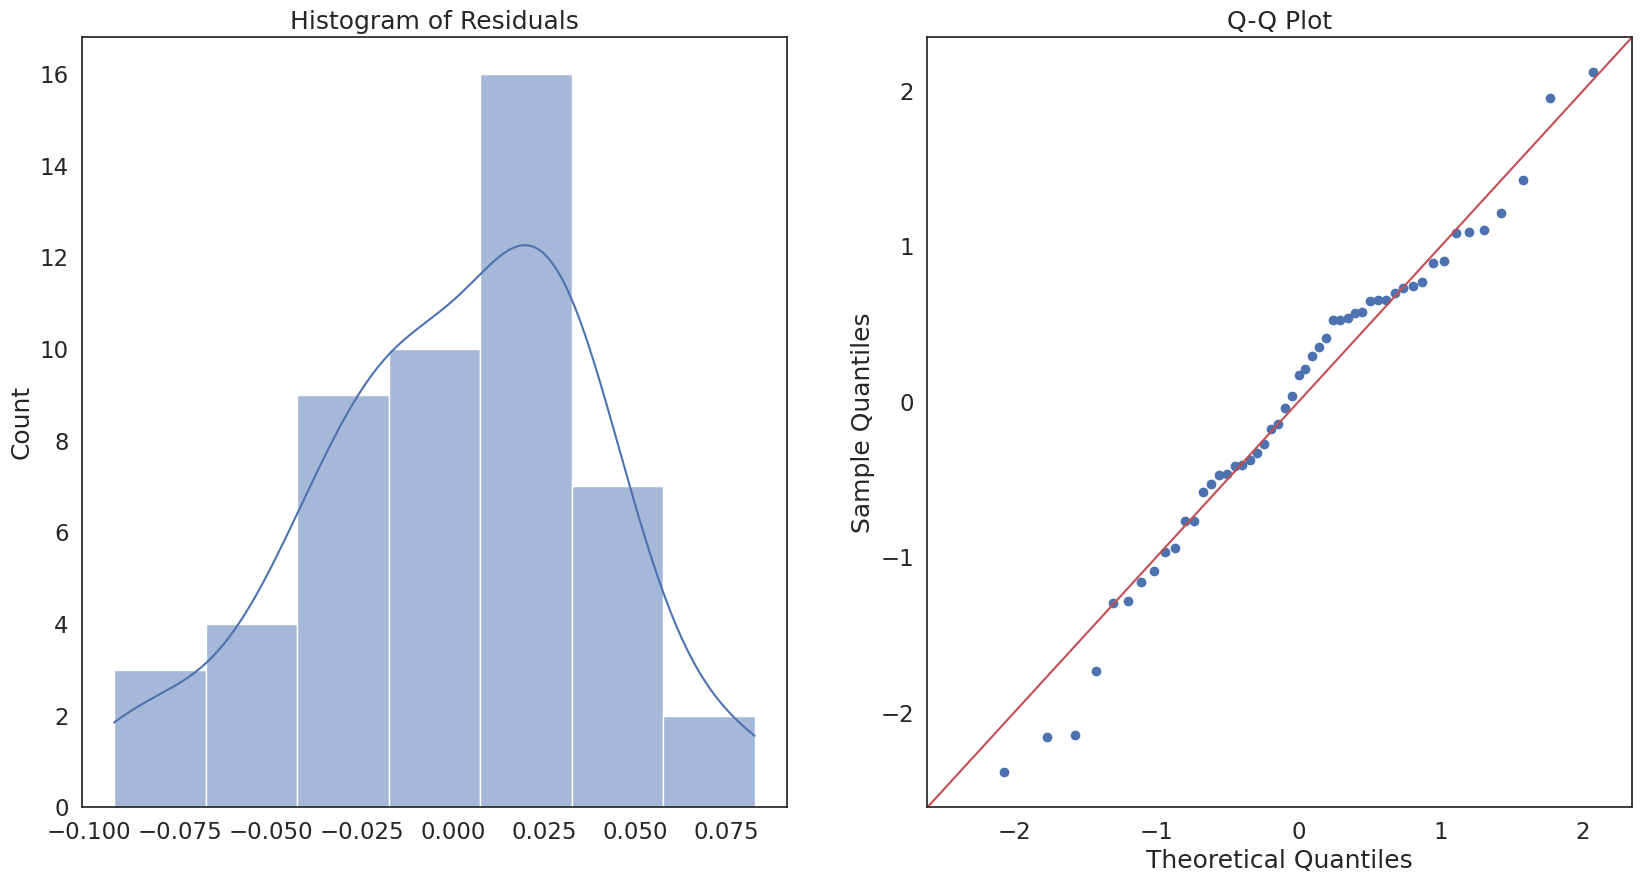

In [20]:
residuals3 = model3.resid # get the residuals

# make the figure wider
plt.rcParams["figure.figsize"] = [20, 10]

f, axes = plt.subplots(1, 2)
sns.histplot(residuals3, kde=True, ax=axes[0]) # plot the residuals
axes[0].set_title('Histogram of Residuals') # add a title

sm.qqplot(residuals3, line='45', fit=True,  ax=axes[1]) # plot the residuals
axes[1].set_title('Q-Q Plot') # add a title

# residuals follow closely to normal distribution

The histogram illustrate a typical bell shape of normal distribution and the Q-Q plot reveals that the residuals lie close to the red line, meaning that the residuals are roughly normally distributed.

Other than political affiliation and religiosity, there may still be some other factors that can contribute to pro-abortion proportion. One example would be gender. Here we try to investigate if the compositions of female and male are similar among the adults who support abortion. This is done by a one sample t-test:


> H0: female composition = 0.5

> H1: female composition != 0.5

We assume female and male populations are similar so we expect the composition to be 50/50 if male and female share similar view (H0).




In [21]:
!curl https://www.ucl.ac.uk/~uclqcl3/BASC0005/Dataset2_women.csv -o data/Dataset2_women.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   868  100   868    0     0    945      0 --:--:-- --:--:-- --:--:--   945


In [22]:
df_female = pd.read_csv("data/Dataset2_women.csv")

df_female.head()

,State,Female composition in adults who support abortion in all/most cases
0,Alabama,0.53
1,Alaska,0.46
2,Arizona,0.52
3,Arkansas,0.49
4,California,0.52


In [23]:
df_female.describe()

,Female composition in adults who support abortion in all/most cases
count,51.000000
mean,0.518824
std,0.025585
min,0.460000
25%,0.500000
50%,0.520000
75%,0.540000
max,0.570000


From the above table, the mean female composition in adults who support abortion in all/most cases is 51.88%, which is slightly higher than 50%. We now do the hypothesis testing to see if the difference (51.88% vs 50%) is statistically significant.

In [24]:
t_test_female = stats.ttest_1samp(df_female['Female composition in adults who support abortion in all/most cases'], popmean=0.5)
t_test_female

TtestResult(statistic=5.254144918156712, pvalue=3.072975926293962e-06, df=50)

The t-statistic is 5.2541 and the p-value is 3.0730e-06 which is less than 1%. So, the null hypothesis is rejected at 1% significance level. Females tend to be more pro-abortion than males.


---


Part II

Source


*   https://www.covidstates.org/reports/state-by-state-views-on-abortion-in-america
*   https://www.multistate.us/issues/2022-state-legislatures
* https://reproductiverights.org/maps/abortion-laws-by-state/





In [25]:
!curl https://www.ucl.ac.uk/~uclqcl3/BASC0005/data2022.csv -o data/data2022.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2882  100  2882    0     0   3526      0 --:--:-- --:--:-- --:--:--  3523


In [26]:
df_2022 = pd.read_csv("data/data2022.csv")
df_2022.head()

,State,Die,Health,Defects,Fetal_heartbeat,Six_week,Fetal_viability,Does_not_want,Financial,Rape,Republican,Democrat,Protected
0,AK,0.62,0.50,0.48,0.34,0.39,0.18,0.41,0.38,0.59,0,0,1
1,AL,0.50,0.30,0.35,0.17,0.18,0.10,0.22,0.21,0.46,1,0,0
2,AR,0.52,0.31,0.36,0.22,0.18,0.10,0.23,0.22,0.50,1,0,0
3,AZ,0.64,0.45,0.50,0.29,0.35,0.16,0.38,0.31,0.64,1,0,0
4,CA,0.62,0.51,0.49,0.34,0.37,0.23,0.47,0.42,0.64,0,1,1


Variables:

* Die: Abortion Support to Protect the Woman’s Life
* Health: Abortion Support to Protect the Woman’s Health
* Defects: Abortion Support For Fetal Health Problems or Birth Defects
* Fetal_heartbeat: Abortion Support After A Fetal Heartbeat Is Detected
* Six_week: Abortion Support After 6 Weeks Of Pregnancy
* Fetal_viability: Abortion Support After Fetal Viability
* Does_not_want: Abortion Support If A Woman Doesn’t Want To Be Pregnant
* Financial: Abortion Support For Financial Reasons
* Rape: Abortion Support In Pregnancy Caused By Rape
* Republican: 1 if the state is republican according to 2022 State Legislative Partisan Control, 0 otherwise
* Democrat: 1 if the state is democratic according to 2022 State Legislative Partisan Control, 0 otherwise
* Protected: 1 if abortion is protected (Expanded Access / Protected) in the state, 0 otherwise

Below is the summary of the variables.


In [27]:
df_2022.describe()

,Die,Health,Defects,Fetal_heartbeat,Six_week,Fetal_viability,Does_not_want,Financial,Rape,Republican,Democrat,Protected
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,0.627647,0.447451,0.474706,0.278824,0.309608,0.167843,0.352745,0.322941,0.610588,0.607843,0.333333,0.450980
std,0.071961,0.076599,0.069638,0.064239,0.078101,0.042252,0.082561,0.072313,0.074146,0.493089,0.476095,0.502543
min,0.480000,0.290000,0.300000,0.160000,0.180000,0.090000,0.220000,0.190000,0.450000,0.000000,0.000000,0.000000
25%,0.585000,0.405000,0.440000,0.235000,0.260000,0.135000,0.295000,0.280000,0.570000,0.000000,0.000000,0.000000
50%,0.640000,0.450000,0.480000,0.280000,0.310000,0.170000,0.350000,0.320000,0.620000,1.000000,0.000000,0.000000
75%,0.670000,0.490000,0.515000,0.315000,0.370000,0.200000,0.405000,0.375000,0.655000,1.000000,1.000000,1.000000
max,0.790000,0.590000,0.630000,0.440000,0.490000,0.270000,0.550000,0.490000,0.770000,1.000000,1.000000,1.000000


We now fit 9 models of abortion support under the 9 circumstances against 'Republican'.

In [28]:
models_2022 = []
for i in ['Die', 'Health', 'Defects', 'Fetal_heartbeat', 'Six_week', 'Fetal_viability', 'Does_not_want', 'Financial', 'Rape']:
  ols_formula = 'Q("' + i + '") ~  Q("Republican")'
  model_2022 = ols(ols_formula, data=df_2022).fit()
  models_2022.append(model_2022)

table_2022=summary_col( # create a regression table
    models_2022, # pass the models to the summary_col function
    stars=True, # add stars denoting the p-values of the coefficient to the table; * p<0.05, ** p<0.01, *** p<0.001
    float_format='%0.3f', # set the decimal places to 3
    model_names=['Die', 'Health', 'Defects', 'Fetal_heartbeat', 'Six_week', 'Fetal_viability', 'Does_not_want', 'Financial', 'Rape'], # set the name of the model
    info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))}) # add the number of observations to the table

print(table_2022)


                   Die      Health   Defects  Fetal_heartbeat  Six_week Fetal_viability Does_not_want Financial    Rape  
-------------------------------------------------------------------------------------------------------------------------
Intercept       0.668***  0.498***  0.523***  0.320***        0.371***  0.199***        0.417***      0.378***  0.658*** 
                (0.014)   (0.015)   (0.013)   (0.012)         (0.014)   (0.008)         (0.014)       (0.013)   (0.014)  
Q("Republican") -0.067*** -0.083*** -0.079*** -0.068***       -0.101*** -0.052***       -0.106***     -0.091*** -0.078***
                (0.019)   (0.019)   (0.017)   (0.016)         (0.017)   (0.010)         (0.019)       (0.016)   (0.018)  
R-squared       0.212     0.287     0.316     0.270           0.407     0.369           0.399         0.388     0.269    
R-squared Adj.  0.196     0.272     0.303     0.255           0.394     0.357           0.386         0.376     0.254    
N               51     

In all the 9 models, 'Republican' is statistically significant at 1% significance level and the coefficients are all negative, meaning that republican states are less pro-abortion no matter what circumstances. However, the R-squared values are low. This may be due to the simplicity of the model (only 1 predictor) and also the simplicity of the predictor which is a dummy variable with value either 0 or 1.

Next, we built a generalized linear model of 'Protected' against 'Republican'. Since the response is binary, binomial distribution with logit link function is used, i.e. a logistic regression model is built.

In [29]:

model_law = glm(formula = "Protected ~ Republican",
                data = df_2022,
                family = sm.families.Binomial()).fit()

model_law.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Protected   No. Observations:                   51
Model:                            GLM   Df Residuals:                       49
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20.198
Date:                Mon, 15 Jan 2024   Deviance:                       40.395
Time:                        18:01:03   Pearson chi2:                     51.0
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4427
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1972      0.745      2.948      0.003       0.736       3.658
Republican    -3.8459      0.891     -4.316      0.000      -5.592      -2.099
==============================================================================
"""

The predictor 'Republican' has a p-value of 0.000 so it is statistically significant at 1%. The coefficient is -3.8459, meaning that the odds of abortion being protected in a republican state on average is $e^{-3.8459} = 2.137\%$ that in a non-republican state. So, a republican state is much less likely to have abortion protected.  

In [34]:
#!pip install linearmodels
import pandas as pd
import seaborn as sns
import numpy as np
import plotly
import plotly.express as px
import warnings
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
sns.set(font_scale=1.5)
sns.set_style("white")
plt.rcParams['figure.figsize'] = (12, 8)

In [35]:
!curl https://storage.googleapis.com/qm2/wk10/geojson-countries-fips.json -o data/wk10/geojson-counties-fips.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to create the file data/wk10/geojson-counties-fips.json: No 
100   198  100   198    0     0    809      0 --:--:-- --:--:-- --:--:--   811
curl: (23) Failure writing output to destination


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import pandas as pd
datamap = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_chloropleth.csv')
datamap.head()

,State Name,State Code,State-Policy,Abortion is Extremely Important in %
0,Alaska,AK,4,41
1,Alabama,AL,1,41
2,Arkansas,AR,1,46
3,Arizona,AZ,2,39
4,California,CA,5,41


In [43]:
import json
import pandas as pd
import plotly.express as px
import geopandas as gpd

data/geojson/us-states.json

In [71]:
state_policy_map = px.choropleth( # plot a choropleth map using the plotly express (px) library
                datamap, # load the dataframe
                locations='State Code', # set the location column to the state code
                locationmode="USA-states",
                scope='usa', # set the scope to the USA, so that it only plots the states
                color='State-Policy', # set the color of the states to correspond to the level of state policy
                color_continuous_scale=px.colors.sequential.Viridis, # set the color scale to Viridis, a commonly used color scale
                range_color=[1, 5], # set the range of the color scale to 1-5
                height=1000,
                labels={'color': 'State Policy'},
                title='Choropleth Map of State Policy')

state_policy_map

In [73]:
abortion_imp_map = px.choropleth( # plot a choropleth map using the plotly express (px) library
                datamap, # load the dataframe
                locations='State Code', # set the location column to the state code
                locationmode="USA-states",
                scope='usa', # set the scope to the USA, so that it only plots the states
                color='Abortion is Extremely Important in %', # set the color of the states to correspond to the abortion importance rate
                color_continuous_scale=px.colors.sequential.Viridis, # set the color scale to Viridis, a commonly used color scale
                range_color=[30, 52], # scaled for the relevant data
                height=1000,
               labels={'color': 'Abortion is Extremely Important in %'},
              title='Choropleth Map of the Importance of Abortion in %')
abortion_imp_map

In [81]:
import plotly
#state_policy_map.to_html()

state_policy_map.write_html("state_policy_map.html")


In [82]:
import os
os.getcwd()

'/content'

In [57]:
import folium
import requests
import pandas

state_geo = requests.get(
    "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json"
).json()

m = folium.Map(location=[48, -102], zoom_start=4)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=datamap,
    columns=["State Code", "State-Policy"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.8,
    legend_name="State Policy Level",
).add_to(m)

folium.LayerControl().add_to(m)

m